# Model building

There are several top notch deep learning frameworks that would suffice for this task; but in this case we'll be using __Tensorflow__ from __Google__.<br> 
Training a CNN from scratch is computationally and timely expensive as a result ML engineers sometimes have to lean towards a faster and reliable process called __Transfer Learning__.<br>
In transfer learning we employ robust models that have been trained on data similar to the ones we have at hand, and perform series of fine-tuning to get a desire output. This method is computationally cheaper and also reliable.  
<br>
For this classification problem we'll employ the __VGG16__ model and fine tune it appropriately. 

In [29]:
# Import necessary packages.
%matplotlib inline
import numpy as np
import absl.logging
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16

absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel("ERROR")

# Important constants.
DATASET_PATH = r"C:\Users\ifunanyaScript\Everything\BrainTumour_DiagnosisApp\data\clean_dataset"
IMAGE_SIZE = 224
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 60

In [2]:
# Load the dataset with the Tensorflow data pipeline.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = (BATCH_SIZE),
)

Found 3000 files belonging to 2 classes.


The dataset is loaded as batches specified by the "batch_size" parameter. In this case, 3000 images batched into sizes of 8. Thus, 375 batches and that would be the length of the dataset.

In [3]:
len(dataset)

375

The target/label_names of this dataset are the names of the sub directories in the _DATASET_PATH_ specified earlier.

In [4]:
# Gets the label names from the dataset object.
label_names = dataset.class_names
label_names

['no_tumour', 'tumour']

When one wants to train a model with a particular dataset, the normal practice is to split said dataset into separate chunks; particularly a training chunk and a testing chunk. The purpose of splitting the data is for evaluation purposes after training the model.  
Most times, ML folks use __scikit-learn's__ ___train_test_split___. In this case, we'll use the ___take___ and ___skip___ attributes of the dataset object which allows us to grab a portion of the dataset by batches.  

The training chunk is always a lot larger that the validation chunk and testing chunk, so that the model is trained on as much data as possible. We'll set aside for training, validation and testing; 80%, 10%, 10% respectively.

In [5]:
train_size = 0.8
print(f"The training dataset should be {int(len(dataset)*train_size)} batches")

The training dataset should be 300 batches


In [6]:
# Takes first 300 batches of the dataset
train_ds = dataset.take(300)
len(train_ds)

300

In [7]:
# Remaining data after the training chunk.
remnant = dataset.skip(300)
len(remnant)

75

In [8]:
val_size = 0.1
print(f"The validation dataset should be {int(len(dataset)*val_size)} batches")

The validation dataset should be 37 batches


In [9]:
# Takes the first 37 batch of the remaining data.
val_ds = remnant.take(37)
len(val_ds)

37

In [10]:
# Takes all the data after the first 37 batches.
test_ds = remnant.skip(37)
len(test_ds)

38

All of these snippets can be wrapped in a simple function.

In [11]:
def chunking(dataset, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, buffer=1000):
    """
    The purpose of this function is to split a dataset into the necessary chunks and return
    said chunks accordingly.
    
    A dataset is passed as an argument and the partitions are made with the predefined split sizes.
    One can also alter the split sizes by changing the values while calling the function.
    """
    
    number_of_batches = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(buffer, seed=321)
    
    train_size = int(train_split*number_of_batches)
    validation_size = int(validation_split*number_of_batches)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(validation_size)
    test_ds = dataset.skip(train_size).skip(validation_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = chunking(dataset)
print(f"""The dataset of 94 batches was chunked as follows: 
{len(train_ds)} batches for the Training dataset, 
{len(val_ds)} batches for the Validation dataset and, 
{len(test_ds)} batches for the Testing dataset.""")

The dataset of 94 batches was chunked as follows: 
300 batches for the Training dataset, 
37 batches for the Validation dataset and, 
38 batches for the Testing dataset.


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Caching is used to improve data retrieval performance by reducing the need to access underlying storage.  
In short, the dataset is cached in memory. This reduces training time because there will be no need open files and read images during each epoch.. The next epochs will reuse the data cached by the cache transformation.

In [14]:
# Layers for data_augmentation, resizing and rescaling.
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.5),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.4)
])

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

The point of transfer learning is to reduce training time by reducing the number of trainable weights. With transfer learning, one can use the optimised weights of a pretrained model together with a few weights from series of modifications to generate a reliably accurate model. In essence, we freeze the weights of the pretrained model, then we train only a few weights from the modifications, thus, reducing computation and time cost. 

There is a crucial things one must do when employing a pretrained model, _i.e_ modifying the input and output layers of the network to achieved desired results.  
For example, the VGG16 network has a final output layer of 1000 classes, but we are trying to classify only two classes. Therefore, we ought to modify the output layer according to the problem at hand.

In [21]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_labels = len(label_names)

# Instantiate the pretrained model.
vgg = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

# Freeze the pretrained model.
vgg.trainable = False

In [23]:
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = resize_and_rescale(x)

x = vgg(x, training=False)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Dense(64)

In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (224, 224, 3)             0         
                                                                 
 sequential (Sequential)     (224, 224, 3)             0         
                                                                 
 input_6 (InputLayer)        multiple                  0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense_6 (Dense)             (None, 7, 7, 64)          32832     
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 dense_7 (Dense)             (None, 7, 7, 2)          

Yowza!!!<br> 
We have to train over 156,000 weights.<br>
This will take a pretty long time using a CPU.<br>
Patience is a virtue.

As we know, backward propagation is one of two fundamental steps in training an __NN__. We'll use Adam optimizer for backward propagation.<br>
This is binary classification problem, __i.e__, no tumour[0] or tumour[1], however, we'll use SparseCategoricalCrossentropy to calculate the loss of the model's prediction compared to the actual labels.<br>
Then we can track our model's performance with an accuracy metric.


__NB:__ Backward propagation is a method sort of differencial calculus where we calculate the gradient of the loss function with respect to the parameters(weights and biases). Then we update said weights and biases according to minimise the loss.

In [27]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

We train the model by fitting it to the training dataset and we validate its performance with the validation dataset.

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/60


C:\Users\ifunanyaScript\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\ifunanyaScript\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ifunanyaScript\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ifunanyaScript\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\ifunanyaScript\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\ifunanyaScript\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ifunanyaScript\AppData\Local\Temp\ipykernel_428\2073589160.py", line 1, in <cell line: 1>
      history = model.fit(
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\engine\training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\ifunanyaScript\anaconda3\lib\site-packages\keras\backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [392,2] and labels shape [8]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_9631]

We'll carry out a final evaluation of the model to see its general performance.<br>
We'll do this using the test dataset; a dataset it has not seen prior.

In [19]:
scores = model.evaluate(test_ds)

38/38 [==============================] - 109s 1s/step - loss: 0.0952 - accuracy: 0.9572


Pretty good performance. Approximately 98% accuracy.  
<br>
<br>
When one fits a model, the process returns a few items; that which we assigned to the ___history___ variable. Let's take a look.

In [20]:
history.params

{'verbose': 1, 'epochs': 80, 'steps': 300}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

These are the keys the training process displayed. Since we ran 100 epochs, each of these keys contain 100 items.

In [22]:
print(len(history.history['accuracy']))
history.history['accuracy']

80


[0.5208333134651184,
 0.5854166746139526,
 0.6245833039283752,
 0.6666666865348816,
 0.6741666793823242,
 0.6966666579246521,
 0.6949999928474426,
 0.7279166579246521,
 0.7362499833106995,
 0.747083306312561,
 0.7579166889190674,
 0.7366666793823242,
 0.7612500190734863,
 0.7887499928474426,
 0.7837499976158142,
 0.8062499761581421,
 0.809583306312561,
 0.8125,
 0.824999988079071,
 0.8395833373069763,
 0.8508333563804626,
 0.85916668176651,
 0.8620833158493042,
 0.8733333349227905,
 0.8808333277702332,
 0.8837500214576721,
 0.8745833039283752,
 0.893750011920929,
 0.8883333206176758,
 0.8912500143051147,
 0.8929166793823242,
 0.90625,
 0.9100000262260437,
 0.9104166626930237,
 0.9104166626930237,
 0.9083333611488342,
 0.9129166603088379,
 0.9208333492279053,
 0.9158333539962769,
 0.9133333563804626,
 0.9358333349227905,
 0.9108333587646484,
 0.9229166507720947,
 0.9254166483879089,
 0.92208331823349,
 0.9316666722297668,
 0.934166669845581,
 0.9237499833106995,
 0.9283333420753479,
 0.

As we can see the first value corresponds with the first accuracy our model achieved in the first epoch. 
  
  
I would like to plot the values of those keys to illustrate how the model got better over each epoch.

In [23]:
# Assign these values to variables.
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

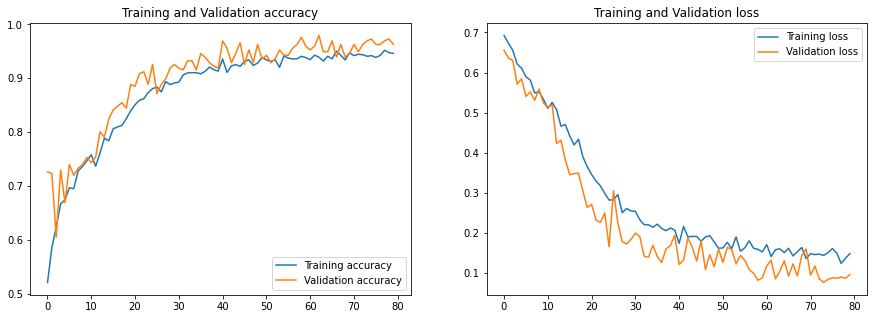

In [24]:
# Expand plot size.
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label="Training accuracy")
plt.plot(range(EPOCHS), val_accuracy, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")

plt.show()

Beautiful!  
From these line plots we can confidently say a 100 epochs wasn't needed. Perhaps 75 should have sufficed.  
It's interesting how we can visualise how accuracy increases and loss decreases.  
  
  
  
### Some extracurricular testing
Let's play with the model...

We'll randomly select an image from _test_ds_; We'll plot this image then print it's actual label and predicted label.

Predicting this image...
Actual label: tumour
1/1 [==============================] - 1s 1s/step
predicted label: tumour


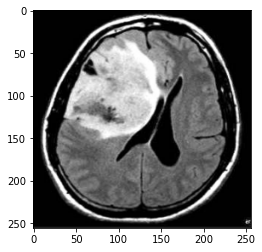

In [49]:
for images_batch, labels_batch in test_ds.take(1):
    image = images_batch[0].numpy().astype("uint8")
    label = labels_batch[0].numpy()
    
    print("Predicting this image...")
    plt.imshow(image)
    print(f"Actual label: {label_names[label]}")
    
    predictions = np.argmax(model.predict(image))
    print(f"predicted label: {label_names[predictions[0][0]]}")

As always, we'll define a function that takes the image and returns the predicted label.

In [62]:
def classify(model, img):
    
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    
    # Create a batch.
    image_array = tf.expand_dims(image_array, 0)
    
    # Get prediction.
    prediction = (model.predict(image_array) > 0.5).astype("int32")
    
    # Get label name
    predicted_label = label_names[prediction[0][0]]
    return predicted_label

Now, we can plot several images and get their predictions using the above function.

1/1 [==============================] - 0s 250ms/step


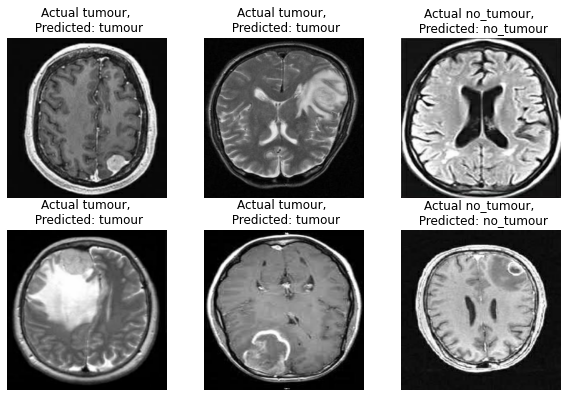

In [64]:
# Expand plot size.
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_label = classify(model, images[i].numpy())
        actual_label = label_names[labels[i]]
        
        plt.title(f"Actual {actual_label}, \n Predicted: {predicted_label}")
        plt.axis("off")

Perfect!  
Everything is working fine.  
Let's go ahead and save the model.

In [68]:
model_version = "binary_model"
model.save(f"C:/Users/ifunanyaScript/Everything/BrainTumour_DiagnosisApp/models/{model_version}")

In [67]:
# ifunanyaScript